In [9]:
import os

import numpy as np
import matplotlib.pyplot as plt

import pydicom
import SimpleITK as sitk

In [10]:
study_dir = "./Sample data/HN-CHUM-001/08-27-1885-PANC. avec C.A. SPHRE ORL   tte et cou  -TP-74220/"

In [11]:
# General functions

def load_dicom_slices(series_dir):    
    # Uses Pydicom
    print("Loading DICOM slices ...")
    
    file_names = sorted(os.listdir(series_dir))
    dicom_files = [pydicom.dcmread(series_dir + fn) for fn in file_names]

    dicom_slices = []
    n_skipped = 0
    for f in dicom_files:
        if hasattr(f, 'SliceLocation'): # Only take the slice if slice location attribute exists
            dicom_slices.append(f)
        else:
            n_skipped += 1
    
    dicom_slices = sorted(dicom_slices, key=lambda sl: sl.SliceLocation) # Sort slices by slice location (starting from feet-side) 
    
    print("Total slices found:", len(dicom_files))
    print("Slices loaded:", len(dicom_slices))
    print("Slices skipped:", n_skipped)
    print("Pixel spacing:", dicom_slices[0].PixelSpacing)
    print("Slice thickness:", dicom_slices[0].SliceThickness)
    print("\n")
    
    return dicom_slices, n_skipped


# TODO
def read_dicom_series(series_dir):
    # Uses SimpleITK
    pass

# TODO
def resample(volume, new_shape):
    # Use SimpleITK
    pass


# CT data

In [12]:
# CT specific Functions

def get_ct_volume(dicom_slices):
    """
    Input --
    dicom_slices: List of pydicom objects (each is a slice)
    ------
    Output --
    ct_volume: Numpy array of shape (rows, columns, slices) 
    """
    ct_vol_shape = list(dicom_slices[0].pixel_array.shape)
    ct_vol_shape.append(len(dicom_slices))
    ct_volume = np.zeros(ct_vol_shape)
    
    rescale_slope = dicom_slices[0].RescaleSlope
    rescale_intercept = dicom_slices[0].RescaleIntercept
    
    for i, sl in enumerate(dicom_slices):
        image2d = sl.pixel_array
        image2d[image2d == -2000] = 0 # Set out-of-bound region values to 0 (to make it same as air) 
        image2d_hu = image2d * rescale_slope + rescale_intercept # Converting to HU
        ct_volume[:,:,i] = image2d_hu
    
    print(f"HU range of the CT volume: ({int(ct_volume.min())}, {int(ct_volume.max())}) ")
    
    return ct_volume


def apply_hu_window(ct_volume, window_level, window_width):
    ct_volume_win = ct_volume.copy()
    
    window_max = window_level + window_width // 2
    window_min = window_level - window_width // 2

    ct_volume_win[ct_volume_win > window_max] = window_max
    ct_volume_win[ct_volume_win < window_min] = window_min
    
    return ct_volume_win


In [13]:
ct_series_dir = study_dir + "3.000000-StandardFull-07232/"


# Pydicom + Numpy style --------------------------

dicom_slices, n_skipped = load_dicom_slices(ct_series_dir) # Get a list of pydicom objects (slices) 

# Convert to a 3d numpy array of pixel values
ct_volume = get_ct_volume(dicom_slices) 
plt.imshow(ct_volume[:,:,80], cmap=plt.cm.bone)
plt.show()

# Apply HU window
ct_volume_win = apply_hu_window(ct_volume, window_level=100, window_width=300)
plt.imshow(ct_volume_win[:,:,80], cmap=plt.cm.bone)
plt.show()

Loading DICOM slices ...
Total slices found: 90
Slices loaded: 90
Slices skipped: 0
Pixel spacing: [0.976562, 0.976562]
Slice thickness: 3.750000


HU range of the CT volume: (-1024, 1964) 


In [ ]:
# SimpleITK style ---------------------------


#TODO

# PET data

In [24]:
# PET specific functions

def get_pet_volume(dicom_slices):
    """
    Input --
    dicom_slices: List of pydicom objects (each is a slice)
    ------
    Output --
    pet_volume: Numpy array of shape (rows, columns, slices) 
    """
    pet_vol_shape = list(dicom_slices[0].pixel_array.shape)
    pet_vol_shape.append(len(dicom_slices))
    pet_volume = np.zeros(pet_vol_shape)
    
    rescale_slope = dicom_slices[0].RescaleSlope
    rescale_intercept = dicom_slices[0].RescaleIntercept
    
    for i, sl in enumerate(dicom_slices):
        image2d = sl.pixel_array
        image2d_rescaled = image2d * rescale_slope + rescale_intercept # Rescale
        pet_volume[:,:,i] = image2d_rescaled
        
    return pet_volume
    

Loading DICOM slices ...
Total slices found: 92
Slices loaded: 91
Slices skipped: 1
Pixel spacing: [3.515625, 3.515625]
Slice thickness: 3.2700


Rescale slope: 0.839418
Rescale Intercept: 0
Pixel value range: (0.0, 27505.209606)


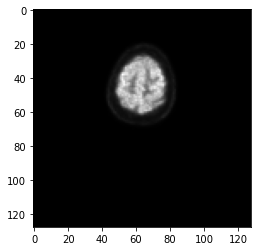

In [25]:
pet_series_dir = study_dir + "4.000000-TETECOUAC2D-27812/"


# Pydicom + Numpy style --------------------------------

dicom_slices, n_skipped = load_dicom_slices(pet_series_dir) # Get a list of pydicom objects (slices)
print("Rescale slope:",dicom_slices[0].RescaleSlope)
print("Rescale Intercept:",dicom_slices[0].RescaleIntercept)

# Get a 3D numpy array of pixel values
pet_volume = get_pet_volume(dicom_slices)
print(f"Pixel value range: ({pet_volume.min()}, {pet_volume.max()})")
plt.imshow(pet_volume[:,:,80], cmap='gray')

In [ ]:
# SimpleITK style ---------------------------


#TODO

# RTstruct data

In [16]:
# Plastimatch to convert to sitk supported binary masks (use the script for the data-pipelines repo)